In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from scipy.stats import norm

# This is just until temporary implementation
import os 
import sys
cwd = os.getcwd()
sys.path.insert(0,cwd + '/../timetransformers')


import Transformer 
from utils import GradualWarmupScheduler


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
device = torch.device("cpu")

In [3]:
import importlib

importlib.reload(Transformer)

output_dim = 3  # To begin with we can use a Gaussian with mean and variance
d_model = 32
num_heads = 1
num_layers = 2
d_ff = 32
max_seq_length = 200
dropout = 0.0
num_distribution_layers = 4

transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    num_distribution_layers,
    device=device,
).to(device)

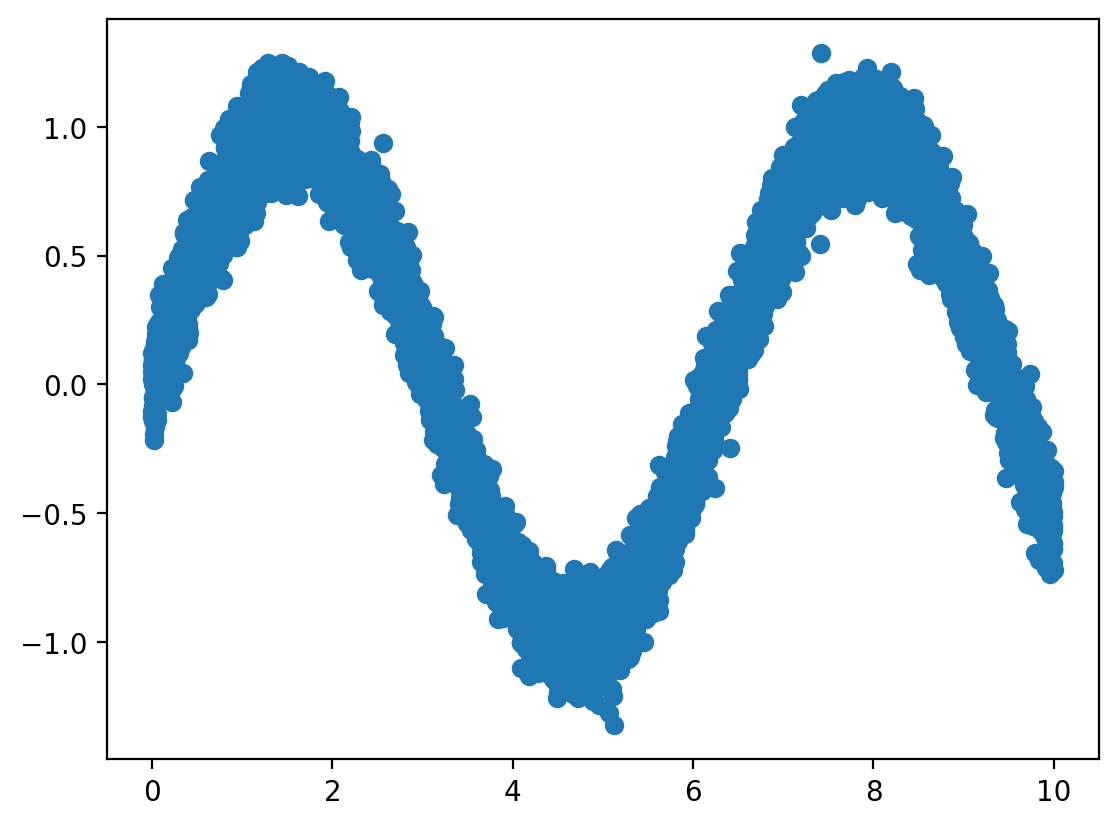

In [4]:
# Ok lets generate some fake time series data
n_data = 10_000
t = np.linspace(0, 10, n_data)
y1 = np.sin(t) + np.random.normal(0, 0.1, n_data)

# Lets plot it
plt.scatter(t, y1)
plt.show()

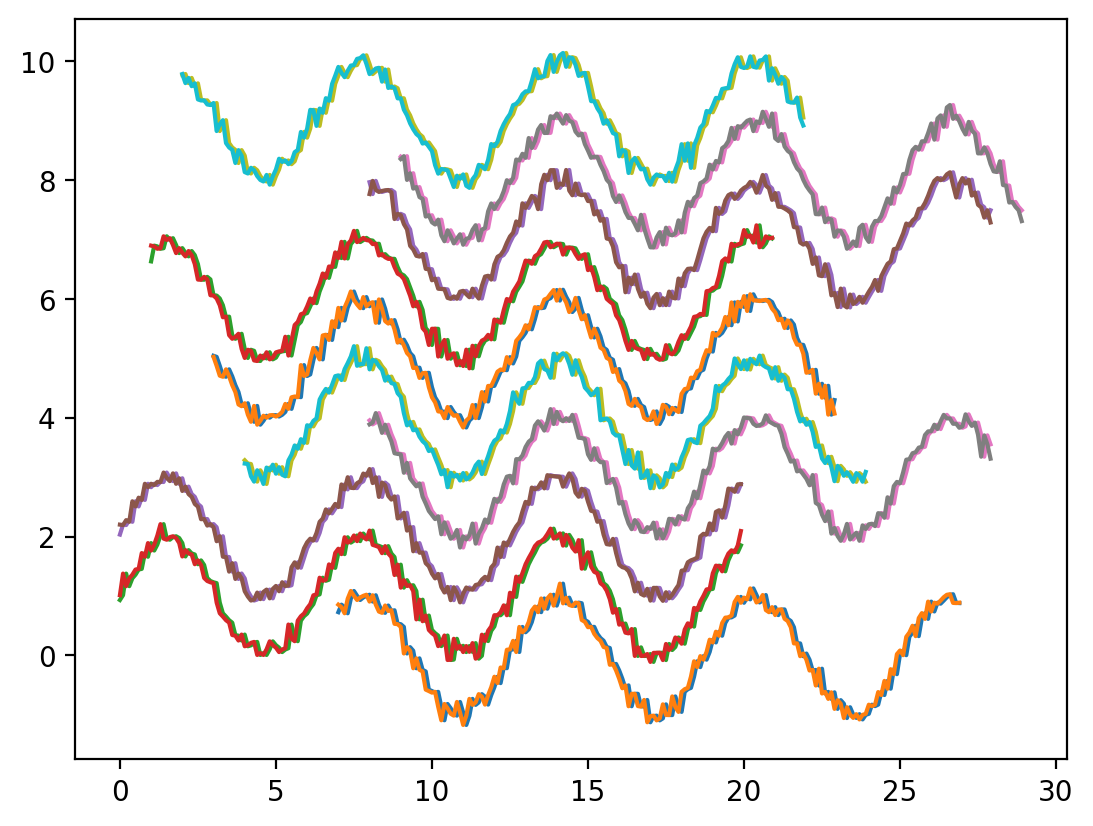

In [5]:
# We now need to package this up into random subsets of time series data
batch_size = 2048


def gen_sin_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,)).to(device)
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 20, max_seq_length + 1
            ).to(device)
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            torch.sin(batch_time).to(device)
            + torch.randn(max_seq_length + 1).to(device) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


def gen_linear_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,))
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, max_seq_length + 1
            )
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            batch_time + torch.randn(max_seq_length + 1) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


times, y_train, y_true = gen_sin_training_data(batch_size)
# times, y_train, y_true = gen_linear_training_data(batch_size)
for i in range(10):
    plt.plot(times[i].cpu(), y_train[i].cpu() + i)
    plt.plot(times[i].cpu(), y_true[i].cpu() + i)

plt.show()

In [6]:
print(y_train.shape, y_true.shape)

torch.Size([2048, 200, 1]) torch.Size([2048, 200])


In [7]:
y_train.shape

torch.Size([2048, 200, 1])

In [8]:
max_learning_rate = 1e-3
optimizer = optim.AdamW(transformer.parameters(), lr=max_learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", patience=50, verbose=True, factor=0.5
# )
Nepochs = 30
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Nepochs, eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=max_learning_rate, total_steps=Nepochs
# )
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=Nepochs, eta_min=1e-6
)
scheduler = GradualWarmupScheduler(
    optimizer,
    total_warmup_steps=4,
    after_scheduler=cosine_scheduler,
)

transformer.train()

losses = []

for rnd in range(Nepochs):
    batch_size = 256
    with tqdm.trange(100) as progress:
        for epoch in progress:
            times, y_train, y_true = gen_sin_training_data(batch_size)
            optimizer.zero_grad()
            output = transformer(y_train)
            loss = transformer.studentT_loss(output, y_true)
            losses.append(loss.item())
            loss.backward()

            optimizer.step()

            progress.set_postfix(ordered_dict={"loss: ": loss.item()})

    scheduler.step()
    current_lr = scheduler.get_lr()[0]
    print(f"Learning Rate = {current_lr}")

100%|██████████| 100/100 [07:11<00:00,  4.31s/it, loss: =1.22]


Learning Rate = 0.00025


 89%|████████▉ | 89/100 [06:13<00:46,  4.20s/it, loss: =-.468] 


KeyboardInterrupt: 

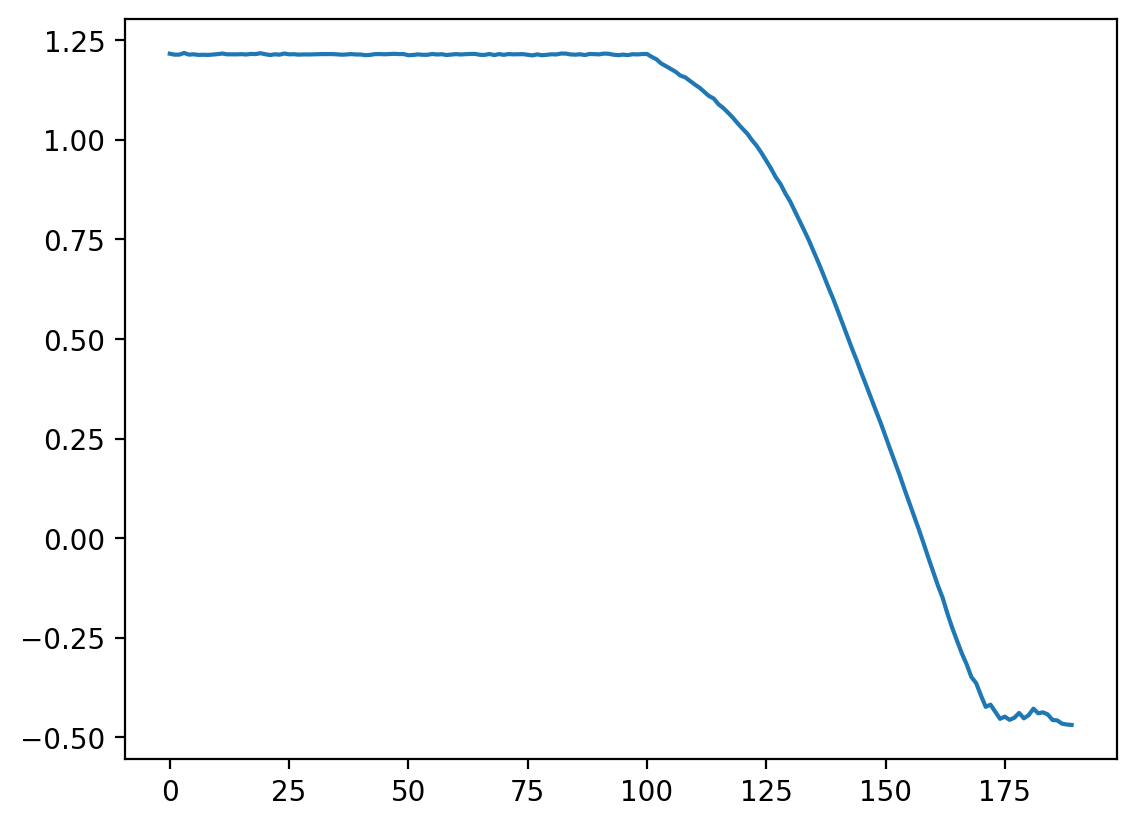

In [9]:
plt.plot(losses)

In [10]:
transformer.eval()
torch.save(transformer.state_dict(), f"test_transformer.pt")

In [9]:
new_transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    num_distribution_layers,
    device=device,
).to(device)
new_transformer.eval()

Decoder_Transformer(
  (embedding_layer): Linear(in_features=1, out_features=32, bias=True)
  (positional_encoding): LearnedPositionalEncoding()
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=32, bias=True)
        (W_k): Linear(in_features=32, out_features=32, bias=True)
        (W_v): Linear(in_features=32, out_features=32, bias=True)
        (W_o): Linear(in_features=32, out_features=32, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=32, out_features=32, bias=True)
        (fc2): Linear(in_features=32, out_features=32, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [12]:
loaded_transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    num_distribution_layers,
    device=device,
)

# loaded_transformer.load_state_dict(torch.load("test_transformer.pt"), strict=True)
# loaded_transformer.train()

# loaded_transformer.train()
# loaded_transformer.load_state_dict(transformer.state_dict())
# loaded_transformer.eval()

In [13]:
print(transformer.state_dict().keys())
print(loaded_transformer.state_dict().keys())

odict_keys(['embedding_layer.weight', 'embedding_layer.bias', 'positional_encoding.pe', 'decoder_layers.0.self_attn.W_q.weight', 'decoder_layers.0.self_attn.W_q.bias', 'decoder_layers.0.self_attn.W_k.weight', 'decoder_layers.0.self_attn.W_k.bias', 'decoder_layers.0.self_attn.W_v.weight', 'decoder_layers.0.self_attn.W_v.bias', 'decoder_layers.0.self_attn.W_o.weight', 'decoder_layers.0.self_attn.W_o.bias', 'decoder_layers.0.feed_forward.fc1.weight', 'decoder_layers.0.feed_forward.fc1.bias', 'decoder_layers.0.feed_forward.fc2.weight', 'decoder_layers.0.feed_forward.fc2.bias', 'decoder_layers.0.norm1.weight', 'decoder_layers.0.norm1.bias', 'decoder_layers.0.norm2.weight', 'decoder_layers.0.norm2.bias', 'decoder_layers.1.self_attn.W_q.weight', 'decoder_layers.1.self_attn.W_q.bias', 'decoder_layers.1.self_attn.W_k.weight', 'decoder_layers.1.self_attn.W_k.bias', 'decoder_layers.1.self_attn.W_v.weight', 'decoder_layers.1.self_attn.W_v.bias', 'decoder_layers.1.self_attn.W_o.weight', 'decoder_la

In [14]:
for key in loaded_transformer.embedding_layer.state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.embedding_layer.state_dict()[key],
            loaded_transformer.embedding_layer.state_dict()[key],
        ),
    )

weight False
bias False


In [15]:
for key in loaded_transformer.positional_encoding.state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.positional_encoding.state_dict()[key],
            loaded_transformer.positional_encoding.state_dict()[key],
        ),
    )

pe False


In [16]:
for key in loaded_transformer.decoder_layers[0].state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.decoder_layers[0].state_dict()[key],
            loaded_transformer.decoder_layers[0].state_dict()[key],
        ),
    )

self_attn.W_q.weight False
self_attn.W_q.bias False
self_attn.W_k.weight False
self_attn.W_k.bias False
self_attn.W_v.weight False
self_attn.W_v.bias False
self_attn.W_o.weight False
self_attn.W_o.bias False
feed_forward.fc1.weight False
feed_forward.fc1.bias False
feed_forward.fc2.weight False
feed_forward.fc2.bias False
norm1.weight False
norm1.bias False
norm2.weight False
norm2.bias False


In [17]:
for key in loaded_transformer.decoder_layers[1].state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.decoder_layers[1].state_dict()[key],
            loaded_transformer.decoder_layers[1].state_dict()[key],
        ),
    )

self_attn.W_q.weight False
self_attn.W_q.bias False
self_attn.W_k.weight False
self_attn.W_k.bias False
self_attn.W_v.weight False
self_attn.W_v.bias False
self_attn.W_o.weight False
self_attn.W_o.bias False
feed_forward.fc1.weight False
feed_forward.fc1.bias False
feed_forward.fc2.weight False
feed_forward.fc2.bias False
norm1.weight False
norm1.bias False
norm2.weight False
norm2.bias False


In [18]:
# for key in loaded_transformer.distribution_head.state_dict().keys():
#     print(
#         key,
#         torch.equal(
#             transformer.distribution_head.state_dict()[key],
#             loaded_transformer.distribution_head.state_dict()[key],
#         ),
#     )

In [19]:
for key in loaded_transformer.distribution_heads[0].state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.distribution_heads[0].state_dict()[key],
            loaded_transformer.distribution_heads[0].state_dict()[key],
        ),
    )

head_layers.0.weight False
head_layers.0.bias False
head_layers.3.weight False
head_layers.3.bias False
head_layers.6.weight False
head_layers.6.bias False
head_layers.9.weight False
head_layers.9.bias False


In [20]:
for key in loaded_transformer.distribution_heads[1].state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.distribution_heads[1].state_dict()[key],
            loaded_transformer.distribution_heads[1].state_dict()[key],
        ),
    )

head_layers.0.weight False
head_layers.0.bias False
head_layers.3.weight False
head_layers.3.bias False
head_layers.6.weight False
head_layers.6.bias False
head_layers.9.weight False
head_layers.9.bias False


In [21]:
for key in loaded_transformer.distribution_heads[2].state_dict().keys():
    print(
        key,
        torch.equal(
            transformer.distribution_heads[2].state_dict()[key],
            loaded_transformer.distribution_heads[2].state_dict()[key],
        ),
    )

head_layers.0.weight False
head_layers.0.bias False
head_layers.3.weight False
head_layers.3.bias False
head_layers.6.weight False
head_layers.6.bias False
head_layers.9.weight False
head_layers.9.bias False


In [22]:
print(transformer.dropout, loaded_transformer.dropout)

Dropout(p=0.0, inplace=False) Dropout(p=0.0, inplace=False)


In [24]:
loaded_transformer.load_state_dict(torch.load("test_transformer.pt"))
loaded_transformer.eval()

Decoder_Transformer(
  (embedding_layer): Linear(in_features=1, out_features=32, bias=True)
  (positional_encoding): LearnedPositionalEncoding()
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=32, bias=True)
        (W_k): Linear(in_features=32, out_features=32, bias=True)
        (W_v): Linear(in_features=32, out_features=32, bias=True)
        (W_o): Linear(in_features=32, out_features=32, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=32, out_features=32, bias=True)
        (fc2): Linear(in_features=32, out_features=32, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (distribution_heads): ModuleList(
    (0-2): 3 x MultiLayerDistributionHead(
 

tensor([ 0.6228,  0.6408,  0.8960,  0.8821,  0.9343,  0.6436,  0.9723,  1.0590,
         1.0073,  1.0360,  0.9074,  0.8504,  0.9036,  0.8725,  0.9661,  0.6138,
         0.5914,  0.5577,  0.6938,  0.2217,  0.0513,  0.1760,  0.0484, -0.0463,
        -0.0066, -0.2325, -0.3021, -0.3605, -0.6918, -0.5916, -0.5990, -0.7955,
        -0.6863, -0.7946, -0.8115, -0.9092, -0.8580, -0.9869, -0.8822, -0.9420,
        -0.9377, -0.8413, -0.9749, -0.9348, -0.9632, -0.9268, -0.8255, -0.8389,
        -0.6307, -0.4446, -0.4321, -0.4469, -0.4254, -0.0778, -0.0122, -0.0809,
         0.0467,  0.2079,  0.2680,  0.2736,  0.3669,  0.5738,  0.7766,  0.7953,
         0.7724,  0.8162,  0.6878,  0.8852,  0.8266,  0.9237,  0.9760,  0.9857,
         0.9336,  0.9755,  0.9123,  0.9360,  0.8929,  0.9484,  0.9095,  0.8237,
         0.6621,  0.3138,  0.4934,  0.3294,  0.1960,  0.1838,  0.2552, -0.0933,
        -0.2445, -0.3495, -0.2977, -0.5181, -0.3240, -0.4783, -0.6983, -0.6842,
        -0.8287, -0.8684, -0.8851, -0.84

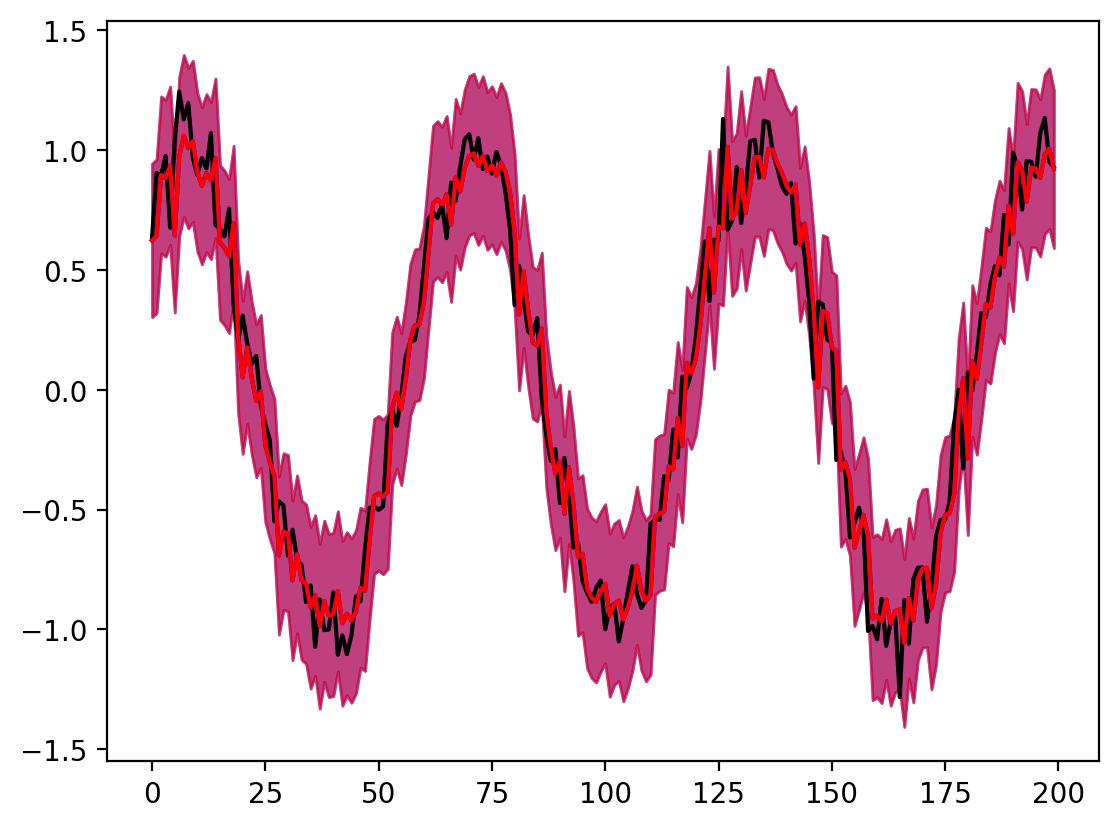

In [25]:
# loaded_transformer = Transformer.Decoder_Transformer(
#     output_dim,
#     d_model,
#     num_heads,
#     num_layers,
#     d_ff,
#     max_seq_length,
#     dropout,
#     num_distribution_layers,
#     device=device,
# )

# loaded_transformer.load_state_dict(transformer.state_dict())
# loaded_transformer.eval()

i = 20
output = transformer(y_train)
new_output = loaded_transformer(y_train)

plt.plot(y_true[i, :].cpu(), "k")
mean = output[i, :, 0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))
print(mean)

new_mean = new_output[i, :, 0].detach().cpu()
new_std = torch.sqrt(torch.nn.functional.softplus(new_output[i, :, 1].detach().cpu()))


plt.plot(mean, "b")
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5, color="b")

plt.plot(new_mean, "r")
plt.fill_between(
    np.arange(mean.shape[0]),
    new_mean - new_std,
    new_mean + new_std,
    alpha=0.5,
    color="r",
)
plt.show()

tensor([ 0.0510, -0.0014,  0.1582,  0.1231,  0.1808,  0.1850,  0.2316,  0.3654,
         0.2666,  0.3824,  0.5114,  0.3801,  0.4750,  0.5239,  0.5266,  0.5044,
         0.5342,  0.5352,  0.5359,  0.5345,  0.5325,  0.5318,  0.5336,  0.5337,
         0.5352,  0.5329,  0.4711,  0.4938,  0.4342,  0.2784,  0.2108,  0.1714,
         0.1782,  0.1503,  0.0423,  0.1041, -0.0073, -0.3498, -0.4952, -0.6864,
        -0.7158, -0.5535, -0.6852, -0.7755, -0.8819, -0.9042, -0.9301, -0.9616,
        -0.9709, -0.9963, -0.9825, -0.9867, -0.9903, -0.9229, -0.9594, -0.9448,
        -0.9045, -0.8994, -0.6913, -0.5078, -0.6362, -0.5115, -0.0282, -0.0736,
        -0.2477,  0.0095,  0.0609,  0.0952,  0.2034,  0.3816,  0.4053,  0.4358,
         0.4790,  0.5190,  0.5222,  0.5348,  0.5357,  0.5354,  0.5343,  0.5361,
         0.5359,  0.5354,  0.5307,  0.5364,  0.5366,  0.5341,  0.5365,  0.4971,
         0.5154,  0.4942,  0.5266,  0.5104,  0.2813,  0.5037,  0.1812,  0.0212,
         0.0156, -0.2937, -0.3792, -0.43

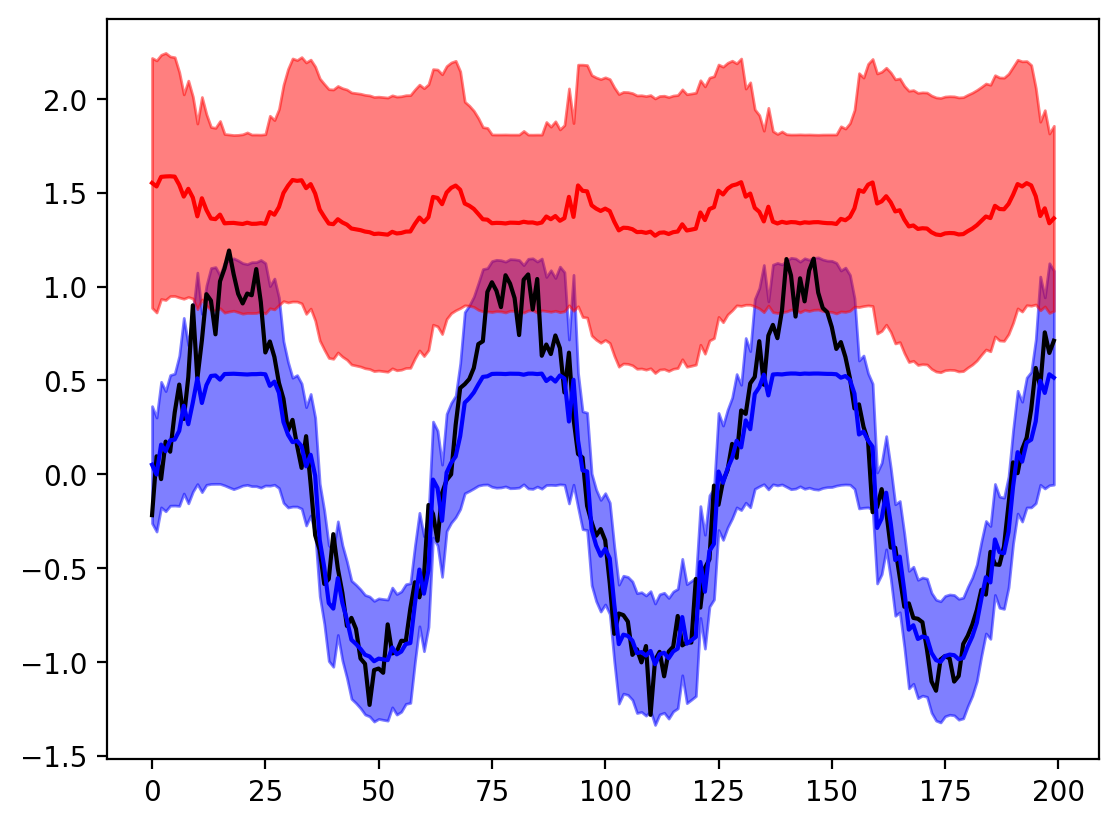

In [76]:
loaded_transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    num_distribution_layers,
    device=device,
)

loaded_transformer.load_state_dict(transformer.state_dict())
loaded_transformer.eval()

i = 20
output = transformer(y_train)
new_output = loaded_transformer(y_train)

plt.plot(y_true[i, :].cpu(), "k")
mean = output[i, :, 0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))
print(mean)

new_mean = new_output[i, :, 0].detach().cpu()
new_std = torch.sqrt(torch.nn.functional.softplus(new_output[i, :, 1].detach().cpu()))


plt.plot(mean, "b")
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5, color="b")

plt.plot(new_mean, "r")
plt.fill_between(
    np.arange(mean.shape[0]),
    new_mean - new_std,
    new_mean + new_std,
    alpha=0.5,
    color="r",
)
plt.show()

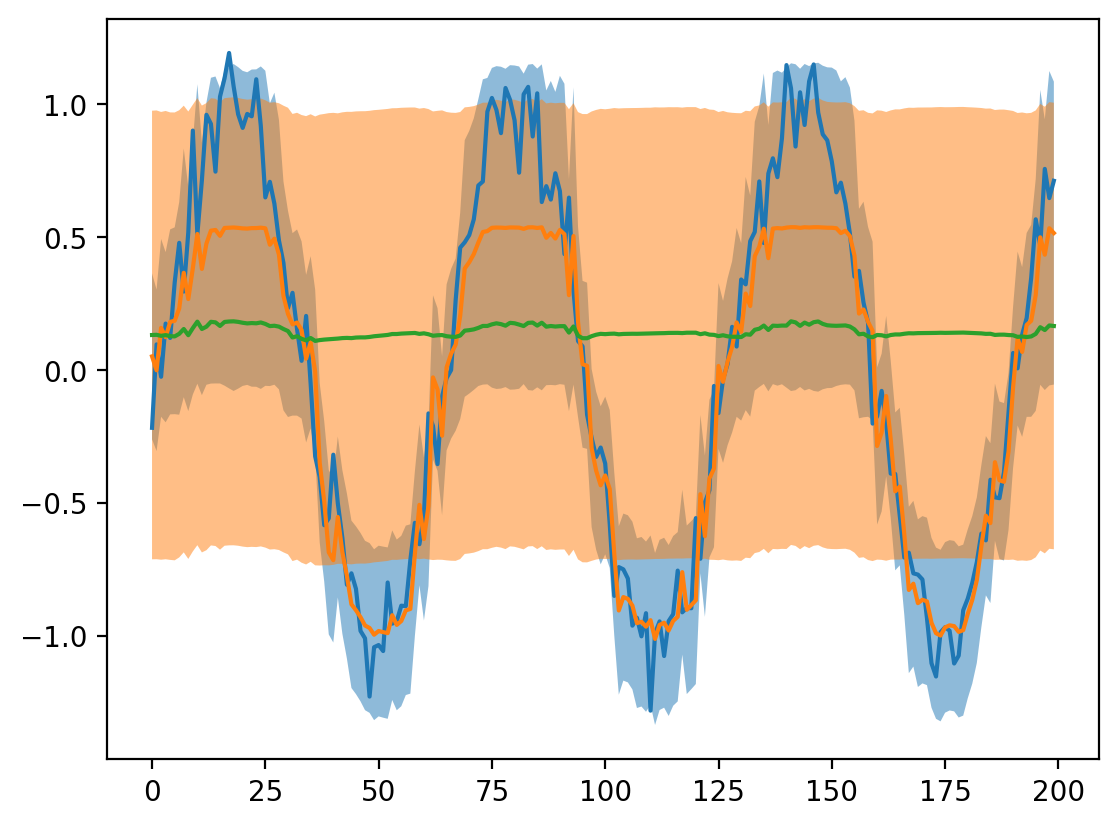

In [64]:
i = 20
output = transformer(y_train)
new_output = new_transformer(y_train)

plt.plot(y_true[i, :].cpu())
mean = output[i, :, 0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))

new_mean = new_output[i, :, 0].detach().cpu()
new_std = torch.sqrt(torch.nn.functional.softplus(new_output[i, :, 1].detach().cpu()))


plt.plot(mean)
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5)

plt.plot(new_mean)
plt.fill_between(
    np.arange(mean.shape[0]), new_mean - new_std, new_mean + new_std, alpha=0.5
)
plt.show()

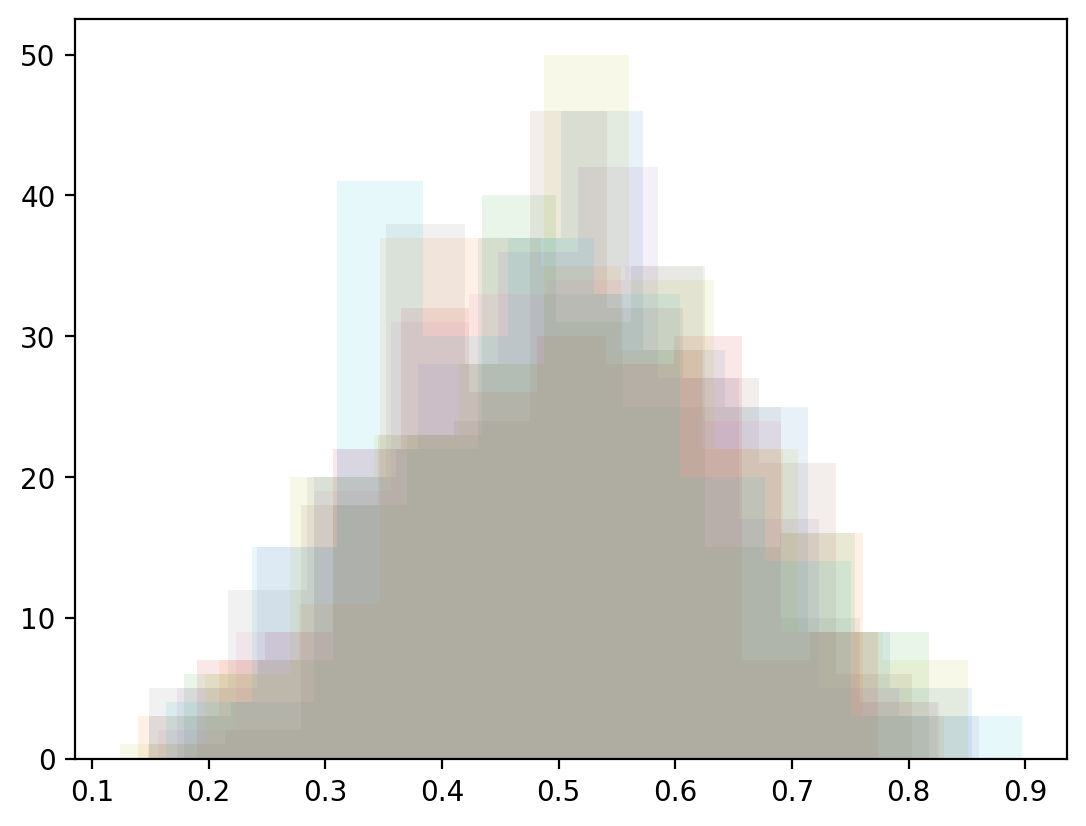

In [12]:
def PIT(transformer_pred, y_true):
    mean = transformer_pred[:, :, 0].cpu().detach().numpy()
    var = torch.nn.functional.softplus(transformer_pred[:, :, 1])
    std = np.sqrt(var.cpu().detach().numpy())

    U = norm.cdf(
        y_true.cpu().detach().numpy(),
        loc=mean,
        scale=std,
    )
    return U


u = PIT(output, y_true)

for i in range(10):
    plt.hist(u[i], alpha=0.1)

plt.show()

100%|██████████| 50/50 [00:00<00:00, 80.50it/s]


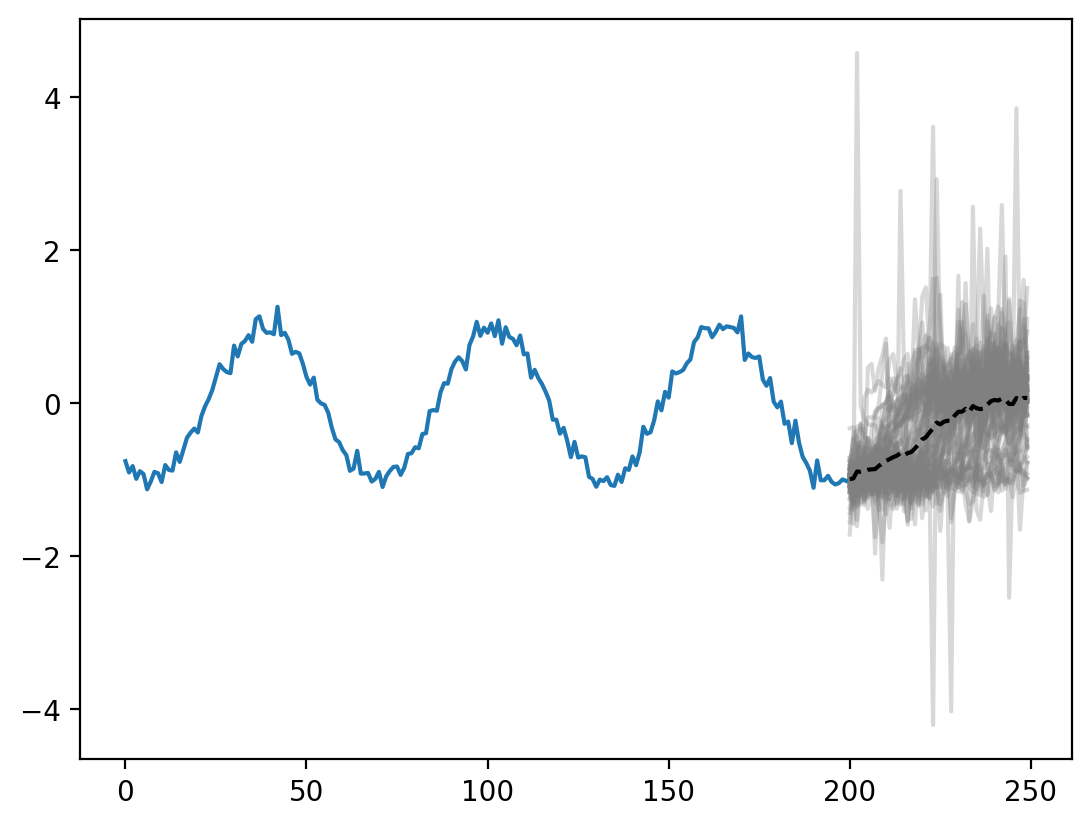

In [32]:
importlib.reload(Transformer)
Nlines = 100
rand_idx = torch.randint(0, y_train.shape[0], (1,))[0]
transformer.eval()

for i in range(Nlines):
    # Generate the next n_sequence elements
    n_sequence = 50
    generated_sequence = []

    # Initial input for the model
    current_input = y_train[rand_idx].unsqueeze(0)

    sequence = transformer.generate(current_input, n_sequence)

    if i == 0:
        sequence_average = sequence
    else:
        sequence_average += sequence
    plt.plot(
        np.arange(y_train[rand_idx].shape[0], y_train[0].shape[0] + sequence.shape[1]),
        sequence[0, :].detach().cpu(),
        alpha=0.3,
        color="grey",
    )

plt.plot(
    np.arange(
        y_train[rand_idx].shape[0], y_train[rand_idx].shape[0] + sequence.shape[1]
    ),
    sequence_average[0, :].detach().cpu() / Nlines,
    color="k",
    ls="--",
)
plt.plot(np.arange(0, y_train[rand_idx].shape[0]), y_train[rand_idx].cpu())
plt.show()

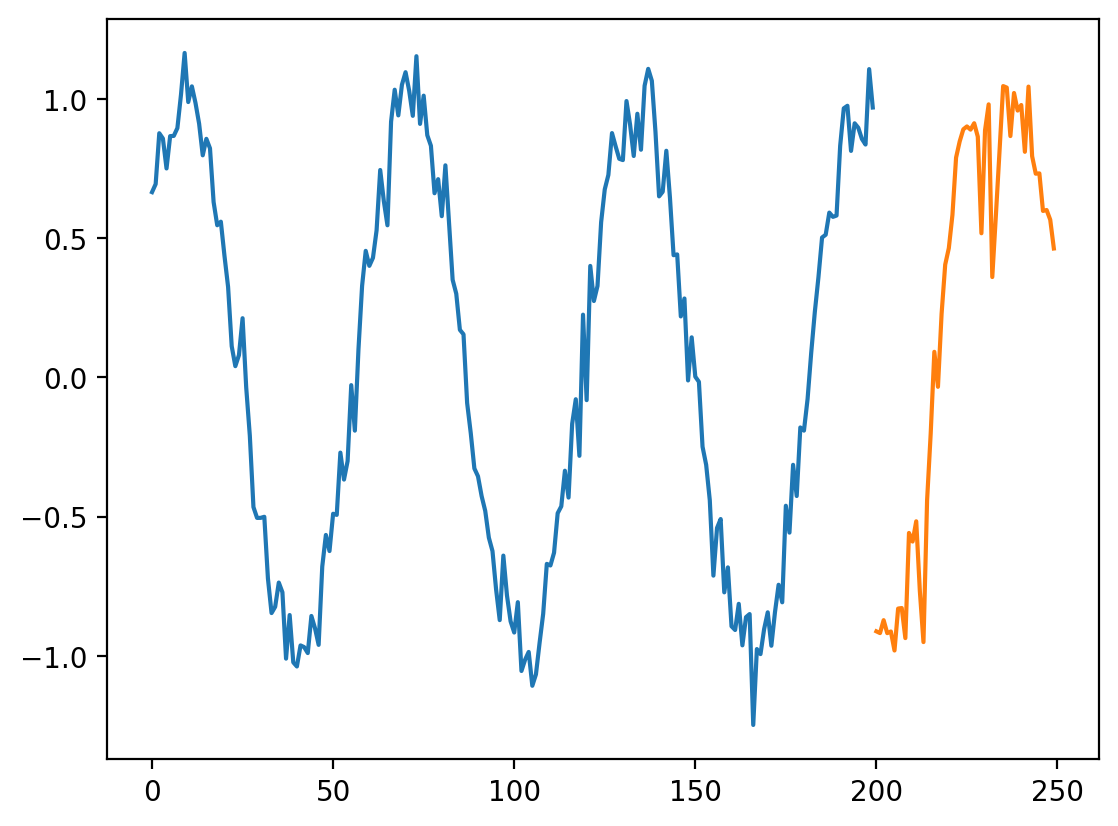

In [15]:
plt.plot(np.arange(0, y_train[0].shape[0]), y_train[0].cpu())
plt.plot(
    np.arange(y_train[0].shape[0], y_train[0].shape[0] + sequence.shape[1]),
    sequence[0, :].detach().cpu(),
)
plt.show()